In [1]:
import glob
import os

import datetime
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import shapely
import xarray as xr
import yaml


%matplotlib inline

In [2]:
comparison_data='/home/soontiensn/data/gpsc-jeh326/sample_model_outputs/cropped_datasets/SalishN01-SalishP01-CIOPSWhourly/'

In [3]:
polygons_file='/home/soontiensn/data/gpsc-work2/OPP/CTD_analysis_domain_config_template-SalishSea.yml'
with open(polygons_file, 'r') as f:
    polygons = yaml.load(f,Loader=yaml.FullLoader)
polygons

{'depth': [0.0, 10.0, 30.0, 50.0, 100.0, 200.0, 400.0],
 'polygon_coords': {'JdF': [[48.4, -123.6],
   [48.62, -124.7],
   [48.37, -124.7],
   [48.14, -124.0],
   [48.1, -123.5]],
  'Puget': [[48.4, -123.6],
   [48.1, -123.5],
   [48.0, -122.8],
   [48.25, -122.72],
   [48.38, -122.63],
   [48.47, -123.0],
   [48.42, -123.32],
   [48.48, -123.46]],
  'GulfIsl': [[48.47, -123.0],
   [48.38, -122.63],
   [48.5, -122.25],
   [48.85, -122.6],
   [48.7, -122.9],
   [48.965, -123.53],
   [49.18, -123.8],
   [49.2, -124.0],
   [48.4, -123.6],
   [48.48, -123.46],
   [48.67, -123.42],
   [48.67, -123.15]],
  'Haro': [[48.47, -123.0],
   [48.67, -123.15],
   [48.67, -123.42],
   [48.48, -123.46],
   [48.42, -123.32]],
  'SoGN': [[49.34, -123.38],
   [49.41, -123.55],
   [50.0, -124.0],
   [50.2, -125.0],
   [50.0, -125.4],
   [49.4, -124.8],
   [49.2, -124.0],
   [49.18, -123.8]],
  'SoGS': [[48.7, -122.9],
   [48.85, -122.6],
   [49.1, -122.85],
   [49.3, -123.0],
   [49.25, -123.3],
   [49.34

# Binning functions
We really need to get these functions into the drift tool so that they can be imported rather than copied.

In [4]:
def weighted_average(data, weights):
    """Caclulate a weighted average. Ignore NaN elements. Sets average to NaN if all weights are zero.
    
    Parameters
    ----------
    data: pandas.DataFrame
        The data to be averaged.
        
    weights: pandas.DataFrame
        The weights for averaging.
        
    Returns
    -------
    avg: float
        The weighted average or np.nan if all elements are NaN."""
    try:
        avg=np.average(data[data.notnull()], weights=weights[data.notnull()])
    except ZeroDivisionError:
        avg=np.nan
    return avg

In [5]:
def grouped_mean(df, skill):
    """Helper function to group a dataframe and then calculate the weighted 
    average of a skill. The dataframe is grouped by time_since_start.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe must have a time_since_start column which are timedeltas.
    skill : str
        Represents the skill to be averaged. (e.g. sep, molcard etc)
        
    Returns
    -------
    df_mean : pandas.DataFrame
        A data frame with the weighted average grouped by hours since start.
    """
    df_grouped = df.groupby('time_since_start')
    df_mean = df_grouped.apply(
        lambda x: pd.Series({skill: weighted_average(x[skill], x['count']),
                             'count': x[x[skill].notnull()]['count'].sum()}))
    df_mean = df_mean.reset_index()
    df_mean['hours since start'] = df_mean.time_since_start.astype('timedelta64[h]')
    return df_mean

In [6]:
def grouped_IQR(df, skill):
    """Helper function to group a dataframe and then calculate the interquartile
    range of a skill. The dataframe is grouped by time_since_start.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe must have a time_since_start column which are timedeltas.
    skill : str
        Represents the skill to be analyzed. (e.g. sep, molcard etc)
        
    Returns
    -------
    df_iqr : pandas.DataFrame
        A data frame with the interquartile range grouped by hours since start.
    """
    df_grouped = df.groupby('time_since_start')
    df_iqr = df_grouped.apply(
        lambda x: pd.Series({'25th percentile': x[skill].quantile(0.25),
                             '75th percentile': x[skill].quantile(0.75)}))
    df_iqr = df_iqr.reset_index()
    df_iqr['hours since start'] = df_iqr.time_since_start.astype('timedelta64[h]')
    return df_iqr

In [7]:
def bin_skills_individual_drifter(ds, skill):
    """Calculate the average skill score for an individual drifter in hourly bins.
    
    Parameters
    ----------
    ds : xarray.Dataset
        The dataset which contains data to be averaged.
        
    skill : str
        The skill to be averaged (e.g. sep, molcard, etc).
        
    Returns
    -------
    drifter_mean : pandas.DataFrame
        A data frame that contains the weighted average of all the tracks for this drifter
        organized into hourly bins.
    all_tracks : pandas.DataFrame
        A data frame that contains the average score for each track 
    """
    all_tracks = pd.DataFrame()
    for m in ds.model_run.values:
        start=datetime.datetime.strptime(str(ds.sel(model_run=m)['mod_start_date'].values), '%Y-%m-%d %H:%M:%S')
        df_track = ds.sel(model_run=m).to_dataframe()
        df_track = df_track.set_index('time')
        # Need to keep track of the counts in order to do the drifter average properly
        # Use base in case model does not start right on the hour.
        df_count= df_track[skill].dropna().sort_index().resample('1H',closed='right', label='right',
                                                                 base=start.minute/60.).count()
        df_track = df_track[skill].dropna().sort_index().resample('1H',closed='right', label='right',
                                                                  base=start.minute/60.).mean()
        df_track = df_track.reset_index()
        df_track['time_since_start'] = df_track['time'] - start
        df_track['model_run'] = m
        df_track['count'] = df_count.values
        all_tracks = pd.concat([all_tracks, df_track])
    all_tracks = all_tracks.reset_index()
    all_tracks['hours since start'] = all_tracks.time_since_start.astype('timedelta64[h]')
    # Now find mean of all tracks
    drifter_mean = grouped_mean(all_tracks, skill)
    return drifter_mean, all_tracks

In [8]:
def bin_skills_all_drifters(ds_list, skill):
    """Calculate the average skill score for an all drifters a model run.
    Average scores are organized into hourly bins.
    
    Parameters
    ----------
    ds_list : list of xarray.Dataset
        The list datasets which should be averaged.
        
    skill : str
        The skill to be averaged (e.g. sep, molcard, etc).
        
    Returns
    -------
    all_mean : pandas.DataFrame
        A data frame that contains the weighted average of all the tracks of all the drifters
        organized into hourly bins.
    all_drifters_all_tracks : pandas.DataFrame
        A data frame that contains the average score for each track for all drifters organized
        into hourly bins.
    """
    all_drifters_all_tracks = pd.DataFrame()
    for ds in ds_list:
        drifter_mean, drifter_tracks = bin_skills_individual_drifter(ds, skill)
        drifter_tracks['obs_buoyid'] = ds.obs_buoyid
        all_drifters_all_tracks = pd.concat([all_drifters_all_tracks, drifter_tracks])
    all_drifter_all_tracks = all_drifters_all_tracks.reset_index()
    all_drifter_all_tracks['hours since start'] = all_drifter_all_tracks.time_since_start.astype('timedelta64[h]')
    # Now find mean of all drifters and all tracks
    all_mean = grouped_mean(all_drifters_all_tracks, skill)
    return all_mean, all_drifters_all_tracks

# Area functions

In [9]:
def refine_regions(datasets, regions, include=True):
    """Refine data to a set of regions
    
    include=True - the regions will be included in refinement
    include=False - the regions will be excluded from refinement"""
    datasets_refined = []
    for d in datasets:
        model_runs = d.model_run.values
        model_runs_in_region = []
        for m in model_runs:
            start_lat= d.mod_start_lat.values[0, m]
            start_lon = d.mod_start_lon.values[0, m]
            point=Point(start_lat,start_lon)
            for r in regions:
                if r.contains(point):
                    model_runs_in_region.append(m)
                    continue
        if include:
            model_runs_include = model_runs_in_region
        else:
            model_runs_include = [m for m in model_runs if m not in model_runs_in_region]
        dnew = d.sel(model_run=model_runs_include)
        if dnew.model_run.size > 0:
            datasets_refined.append(dnew)
    return datasets_refined

# Experiment with excluding JdF

In [10]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

names = ['SoGS', 'SoGN', 'Howe', 'VH', 'GulfIsl', 'Haro']
names2 = [ 'JdF', 'Puget']

regions = [Polygon(polygons['polygon_coords'][name]) for name in names]
regions_JdF = [Polygon(polygons['polygon_coords'][name]) for name in names2]

In [11]:
files = glob.glob(os.path.join(comparison_data, '*.nc'))
files.sort()

In [12]:
datasets_all= []
for f in files:
    d = xr.open_dataset(f)
    datasets_all.append(d)

In [13]:
datasets_no_JdF = refine_regions(datasets_all, regions, include=True)
datasets_JdF = refine_regions(datasets_all, regions_JdF, include=True)

Reorganize

In [14]:
dataset_per_set_all={}
for setname in datasets_all[0].setname.values:
    dataset_per_set_all[setname] = [datasets_all[0].sel(setname=setname),]
    if len(datasets_all) > 1:
        for dataset in datasets_all[1:]:
            dataset_per_set_all[setname].append(dataset.sel(setname=setname))

In [15]:
dataset_per_set_no_JdF={}
for setname in datasets_no_JdF[0].setname.values:
    dataset_per_set_no_JdF[setname] = [datasets_no_JdF[0].sel(setname=setname),]
    if len(datasets_no_JdF) > 1:
        for dataset in datasets_no_JdF[1:]:
            dataset_per_set_no_JdF[setname].append(dataset.sel(setname=setname))

In [16]:
dataset_per_set_JdF={}
for setname in datasets_JdF[0].setname.values:
    dataset_per_set_JdF[setname] = [datasets_JdF[0].sel(setname=setname),]
    if len(datasets_JdF) > 1:
        for dataset in datasets_JdF[1:]:
            dataset_per_set_JdF[setname].append(dataset.sel(setname=setname))

Plotting

In [17]:
def plot_starting_points(ax, bmap, datasets):
    for d in datasets:
        for m in d.model_run.values:
            start_lat = d.sel(model_run=m).mod_start_lat
            start_lon = d.sel(model_run=m).mod_start_lon
            x, y = bmap(start_lon, start_lat)
            ax.plot(x,y,'r.')

/home/soontiensn/miniconda/envs/shapely/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
/home/soontiensn/miniconda/envs/shapely/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/home/soontiensn/miniconda/envs/shapely/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


Text(0.5, 1.0, 'JdF')

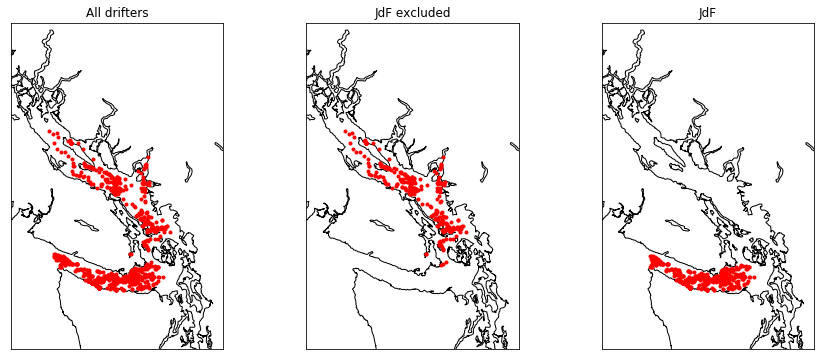

In [18]:
fig,axs = plt.subplots(1,3, figsize=(15,6))
# All
ax=axs[0]
m = Basemap(projection='merc',llcrnrlat=47.5,urcrnrlat=51,llcrnrlon=-125.5,urcrnrlon=-122,resolution='h',ax=ax)
plot_starting_points(ax, m, dataset_per_set_all['SalishP01'])
m.drawcoastlines()
ax.set_title('All drifters')
# No JdF
ax=axs[1]
m = Basemap(projection='merc',llcrnrlat=47.5,urcrnrlat=51,llcrnrlon=-125.5,urcrnrlon=-122,resolution='h',ax=ax)
plot_starting_points(ax, m, dataset_per_set_no_JdF['SalishP01'])
m.drawcoastlines()
ax.set_title('JdF excluded')
# JdF
ax=axs[2]
m = Basemap(projection='merc',llcrnrlat=47.5,urcrnrlat=51,llcrnrlon=-125.5,urcrnrlon=-122,resolution='h',ax=ax)
plot_starting_points(ax, m, dataset_per_set_JdF['SalishP01'])
m.drawcoastlines()
ax.set_title('JdF')

In [19]:
def plot_skill(skill, datasets, ax):
    n=len(datasets.keys())
    colors_dict = {setname: cm.viridis(np.linspace(0, 1, n))[i] for i, setname in enumerate(datasets.keys())}
    for setname, datasets in datasets.items():
        all_mean, all_drifters_all_tracks = bin_skills_all_drifters(datasets, skill)
        # Exclude initial positions from analysis
        all_drifters_all_tracks = all_drifters_all_tracks[all_drifters_all_tracks['hours since start'] != 0]
        # plotting
        all_mean = all_mean[all_mean['hours since start'] != 0]
        ax.plot(all_mean['hours since start'],
                all_mean[skill],lw=4,
                color=colors_dict[setname],
                label=setname)
        iqr = grouped_IQR(all_drifters_all_tracks, skill)
        ax.plot(iqr['hours since start'],
                iqr['25th percentile'],
                lw=1, color=colors_dict[setname], zorder=0,
                ls='--', label='__no_legend__')
        ax.plot(iqr['hours since start'],
                iqr['75th percentile'],
                lw=1,color=colors_dict[setname], zorder=0,
                ls='--', label='__no_legend__')
    ax.set_ylabel(skill)
    ax.set_xlim([0,48])
    ax.legend()
    ax.grid()
    ax.set_xlabel('hours since start')

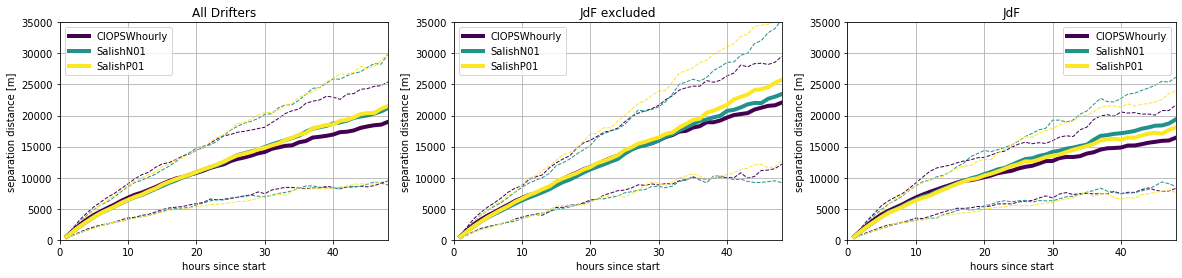

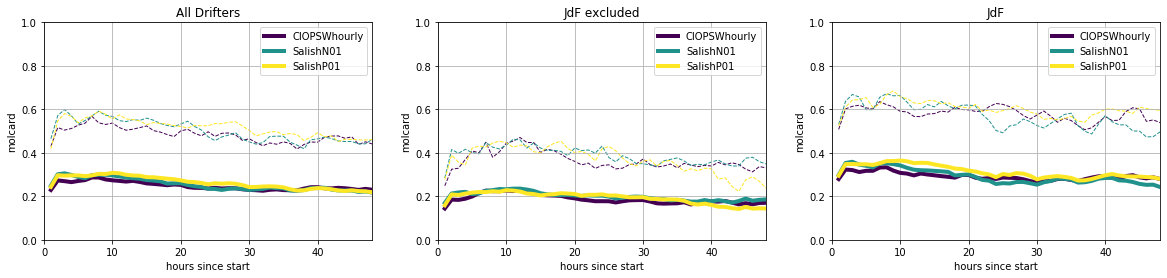

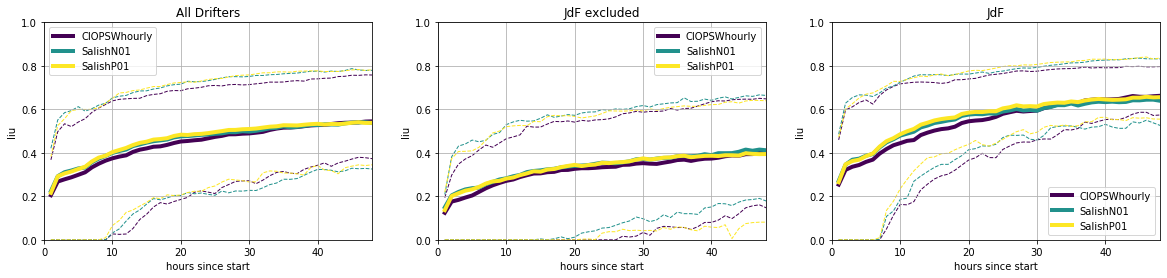

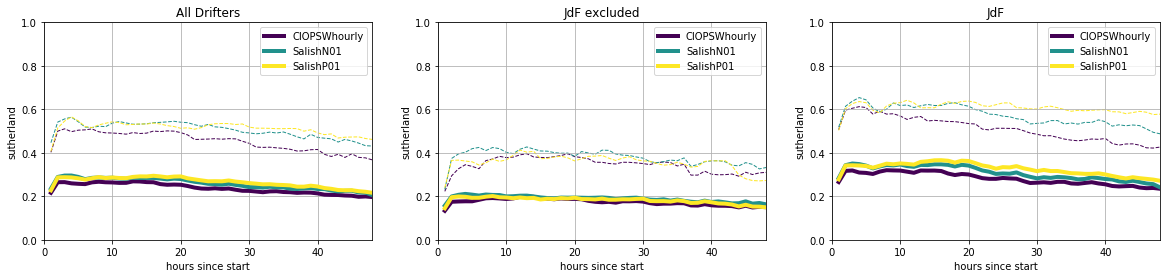

In [20]:
for skill in ['sep', 'molcard']:
    fig,axs=plt.subplots(1,3, figsize=(20,4))
    ax=axs[0]
    plot_skill(skill, dataset_per_set_all, ax)
    ax.set_title('All Drifters')
    ax=axs[1]
    plot_skill(skill, dataset_per_set_no_JdF, ax)
    ax.set_title('JdF excluded')
    ax=axs[2]
    plot_skill(skill, dataset_per_set_JdF, ax)
    ax.set_title('JdF')
    for ax in axs:
        ax.set_ylim([0,1])
        if skill == 'sep':
            ax.set_ylabel('separation distance [m]')
            ax.set_ylim([0,35000])